In [8]:
%config IPCompleter.greedy=True
import re
import json
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from elasticsearch import Elasticsearch
from elasticsearch.helpers import parallel_bulk
from elasticsearch.helpers import bulk
from sklearn.feature_extraction.text import CountVectorizer
import requests
from time import time
import csv
import pandas as pd

In [2]:
es = Elasticsearch("http://localhost:9200")

In [9]:
from elasticsearch import Elasticsearch

ELASTIC_PASSWORD = 'VnZeIgOGEy9dXmGP4SGoJgTM'

# Found in the 'Manage Deployment' page
CLOUD_ID = 'My_deployment:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvOjQ0MyQ0NmE5OTk3YmZjNmU0MzJmYTY5NzMyNmY0OWM4M2I4MSRjMTQyZmNjMjk5Y2M0NWI5ODFjYTI5ZWVkMTI5NmE1YQ=='
# Create the client instance
es = Elasticsearch(
    cloud_id = CLOUD_ID,
    basic_auth=('elastic', ELASTIC_PASSWORD)
)

# Successful response!
es.info()
# {'name': 'instance-0000000000', 'cluster_name': ...}

ObjectApiResponse({'name': 'instance-0000000001', 'cluster_name': '46a9997bfc6e432fa697326f49c83b81', 'cluster_uuid': 'DYLCEqnyQNq1uGMkzCFsGg', 'version': {'number': '8.6.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '2d58d0f136141f03239816a4e360a8d17b6d8f29', 'build_date': '2023-02-13T09:35:20.314882762Z', 'build_snapshot': False, 'lucene_version': '9.4.2', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [11]:
es.indices.create(index='words')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'words'})

In [10]:
es.indices.delete(index='words')

ObjectApiResponse({'acknowledged': True})

In [12]:
def recreate_index_stem():
    es.indices.delete(index='words')
    es.indices.create(index='words', body = settings_stem)

In [13]:
def recreate_index_nostem():
    es.indices.delete(index='words')
    es.indices.create(index='words', body = settings_nostem)

In [14]:
def check_analyzer(analyzer, text):
    body = analyzer
    body['text'] = text
    
    tokens = es.indices.analyze(index='words', body=body)['tokens']
    tokens = [token_info['token'] for token_info in tokens]
    return tokens

In [15]:
settings_stem = {
    'mappings': {
        'properties': {
            'id_right': {
                'type': 'integer'
            },
            'text_right': {
                'type': 'text',
                'fields': {
                    'analyze':{
                        'type': 'text',
                        'analyzer': 'my_analyzer'
                    }
                }
            }
        }
    },
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer':{
                    'type': 'custom',
                    'tokenizer': 'white_20',
                    'filter': [
                        'lowercase',
                        'english_snow'
                    ]
                }
            },
            'tokenizer': {
                'white_20': {
                    'type': 'whitespace',
                }
            },
            'filter': {
                'english_snow':{
                    'type': 'snowball',
                    'language': 'english'
                }
            }
        }
    }
    
}

In [16]:
settings_nostem = {
    'mappings': {
        'properties': {
            'id_right': {
                'type': 'integer'
            },
            'text_right': {
                'type': 'text',
                'fields': {
                    'analyze':{
                        'type': 'text',
                        'analyzer': 'my_analyzer'
                    }
                }
            },
        }
    },
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer':{
                    'tokenizer': 'white_20',
                    'filter': [
                        'lowercase',
                    ]
                }
            },
            'tokenizer': {
                'white_20': {
                    'type': 'whitespace',
                }
            },
        }
    }
}

In [129]:
recreate_index_nostem()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\2148422484.py:3: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index='words', body = settings_nostem)


In [130]:
df = pd.read_csv('documents.csv')
data = df.to_dict('records')

In [19]:
def create_es_action(index, doc_id, document):
    return {
        '_index': index,
        '_id': doc_id,
        '_source': document
    }

def es_actions_generator():
    for doc in data:
        yield create_es_action('words', doc['id_right'], doc)

In [131]:
for ok, result in parallel_bulk(es, es_actions_generator(), queue_size=4, thread_count=4, chunk_size=1000,request_timeout = 30):
    if not ok:
        print(result)

In [132]:
def search(query, *args):
    pretty_print_result(es.search(index='words', body=query, size=20), args)
    # note that size set to 20 just because default value is 10 and we know that we have 12 docs and 10 < 12 < 20
                        
def pretty_print_result(search_result, fields=[]):
    # fields is a list of fields names which we want to be printed
    res = search_result['hits']
    print(f'Total documents: {res["total"]["value"]}')
    for hit in res['hits']:
        print(f'Doc {hit["_id"]}, score is {hit["_score"]}')
        for field in fields:
            print(f'{field}: {hit["_source"][field]}')
                  
def get_doc_by_id(doc_id):
    return es.get(index='words', id=doc_id)['_source']

In [133]:
query = {
    'query': {
        'match_all': {}
    }
}

search(query)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\3128239079.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  pretty_print_result(es.search(index='words', body=query, size=20), args)


Total documents: 10000
Doc 1555943, score is 1.0
Doc 2074038, score is 1.0
Doc 19044, score is 1.0
Doc 1121717, score is 1.0
Doc 1652584, score is 1.0
Doc 909089, score is 1.0
Doc 309490, score is 1.0
Doc 828315, score is 1.0
Doc 2099304, score is 1.0
Doc 1307767, score is 1.0
Doc 1342445, score is 1.0
Doc 2006202, score is 1.0
Doc 2050844, score is 1.0
Doc 2431149, score is 1.0
Doc 505721, score is 1.0
Doc 2414484, score is 1.0
Doc 266667, score is 1.0
Doc 1895927, score is 1.0
Doc 1696612, score is 1.0
Doc 1179910, score is 1.0


In [23]:
text = 'the final round was held in rio de janeiro brazil the following is the brazilian roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb volleyball world league the following is the roster in the 2008 fivb'

In [24]:
analyzer = {
    'analyzer': 'my_analyzer'
}

check_analyzer(analyzer, text)


C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\2247034190.py:5: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  tokens = es.indices.analyze(index='words', body=body)['tokens']


['the',
 'final',
 'round',
 'was',
 'held',
 'in',
 'rio',
 'de',
 'janeiro',
 'brazil',
 'the',
 'follow',
 'is',
 'the',
 'brazilian',
 'roster',
 'in',
 'the',
 '2008',
 'fivb',
 'volleybal',
 'world',
 'leagu',
 'the',
 'follow',
 'is',
 'the',
 'roster',
 'in',
 'the',
 '2008',
 'fivb',
 'volleybal',
 'world',
 'leagu',
 'the',
 'follow',
 'is',
 'the',
 'roster',
 'in',
 'the',
 '2008',
 'fivb',
 'volleybal',
 'world',
 'leagu',
 'the',
 'follow',
 'is',
 'the',
 'roster',
 'in',
 'the',
 '2008',
 'fivb',
 'volleybal',
 'world',
 'leagu',
 'the',
 'follow',
 'is',
 'the',
 'roster',
 'in',
 'the',
 '2008',
 'fivb',
 'volleybal',
 'world',
 'leagu',
 'the',
 'follow',
 'is',
 'the',
 'roster',
 'in',
 'the',
 '2008',
 'fivb',
 'volleybal',
 'world',
 'leagu',
 'the',
 'follow',
 'is',
 'the',
 'roster',
 'in',
 'the',
 '2008',
 'fivb',
 'volleybal',
 'world',
 'leagu',
 'the',
 'follow',
 'is',
 'the',
 'roster',
 'in',
 'the',
 '2008',
 'fivb',
 'volleybal',
 'world',
 'leagu',


In [25]:
%%time

query = {
    'query': {
        'bool': {
            'must': {
                'match': {
                    'text_right': 'great lakes'
                }
            }
        }
    }
}

search(query)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\3128239079.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  pretty_print_result(es.search(index='words', body=query, size=20), args)


Total documents: 10000
Doc 973440, score is 15.704821
Doc 4900, score is 15.335167
Doc 1439087, score is 14.825996
Doc 1322917, score is 14.652464
Doc 2064714, score is 14.652464
Doc 1445071, score is 14.344378
Doc 617105, score is 13.750026
Doc 2334631, score is 13.677895
Doc 1217601, score is 13.677895
Doc 1374404, score is 13.677895
Doc 1037110, score is 13.481821
Doc 325041, score is 13.323684
Doc 2326221, score is 13.323684
Doc 347207, score is 13.175156
Doc 1961850, score is 12.748814
Doc 1227346, score is 12.694827
Doc 1879210, score is 12.694827
Doc 2292393, score is 12.694827
Doc 1858796, score is 12.694827
Doc 1945210, score is 12.694827
CPU times: total: 31.2 ms
Wall time: 4.26 s


In [145]:
import numpy as np

q = pd.read_csv('queries.csv')
runs = {}

q = q.reset_index()
runs = {}
for ind, row in q.iterrows():
    query = {
        'query': {
            'bool': {
                'must': {
                    'match': {
                        'text_right': row['text_left']
                    }
                }
            }
        }
    }
    results = es.search(index = 'words', body = query, size = 20)
    res = results['hits']
    temp = {}
    for hit in res['hits']:
        doc_id = str(hit['_id'])
        score = int(round(float(hit['_score'])))
        temp[doc_id] = score
    runs[str(row['id_left'])] = temp

C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\2362643977.py:20: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.search(index = 'words', body = query, size = 20)


In [121]:
qrel = pd.read_csv('BM25.qrels.csv')
qrel = qrel.reset_index()
qrels = {}
i = 0
d = {}
sum = 0
for ind, row in qrel.iterrows():
    if i != 0:
        if str(row['id_left']) != temp:
            qrels[temp] = d
            d = {}
            temp = str(row['id_left'])
            sum = sum + 1

        else:
            d[str(row['id_right'])] = int(row['label'])
                       
    else:
        temp = str(row['id_left'])
        i = i + 1
        d[str(row['id_right'])] = int(row['label'])
qrels[str(712704)] = d

In [147]:
import ir_measures
from ir_measures import *

ir_measures.calc_aggregate([P@10, P@20, AP], qrels, runs)

{AP: 0.09504329116848373, P@10: 0.5439999999999996, P@20: 0.5625000000000001}

In [127]:
df = pd.read_csv('BM25.res')

i = 0
d = {}
creators_runs = {}

for j in df['158491 Q0 625257 0 15.660703104969318 BM25']:
    if i != 0:
        if str(j.split()[0]) != temp:
                creators_runs[temp] = d
                d = {}
                temp = str(j.split()[0])

        else:
                d[str(j.split()[2])] = int(round(float(j.split()[4])))

    else:
            temp = str(j.split()[0])
            i = i + 1
            d[str(j.split()[2])] = int(round(float(j.split()[4])))
    creators_runs[str(712704)] = d
    
creators_runs['158491']['625257'] = 15

In [128]:
print(ir_measures.calc_aggregate([AP, P@10, P@20], qrels, creators_runs))

{AP: 0.989054295650095, P@10: 0.9760000000000002, P@20: 0.9860000000000005}


In [148]:
x_map_nostem = []
y = []
for i in range(20, 800, 20):
    
    q = pd.read_csv('queries.csv')
    runs = {}

    q = q.reset_index()
    runs = {}
    for ind, row in q.iterrows():
        query = {
            'query': {
                'bool': {
                    'must': {
                        'match': {
                            'text_right': row['text_left']
                        }
                    }
                }
            }
        }
        results = es.search(index = 'words', body = query, size = i)
        res = results['hits']
        temp = {}
        for hit in res['hits']:
            doc_id = str(hit['_id'])
            score = int(round(float(hit['_score'])))
            temp[doc_id] = score
        runs[str(row['id_left'])] = temp
    a = ir_measures.calc_aggregate([AP], qrels, runs)
    y.append(i)
    x_map_nostem.append(a[AP])

C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\3663313419.py:22: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.search(index = 'words', body = query, size = i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\3663313419.py:22: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.search(index = 'words', body = query, size = i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\3663313419.py:22: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.search(index = 'words', body = query, size = i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17236\3663313419.py:22: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.

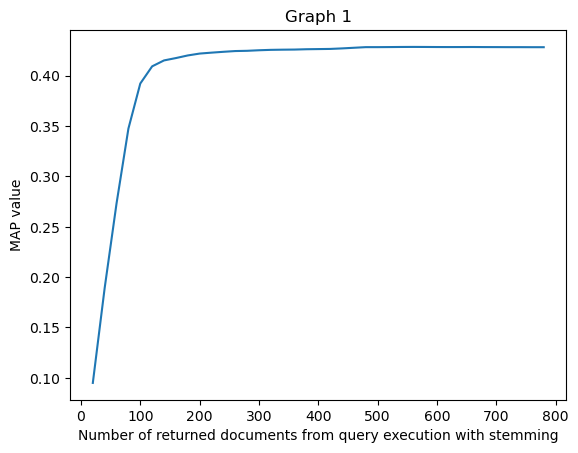

In [152]:
import matplotlib.pyplot as plt

plt.plot(y, x_map)
plt.xlabel('Number of returned documents from query execution with stemming')
plt.ylabel('MAP value')
plt.title('Graph 1')
plt.show()

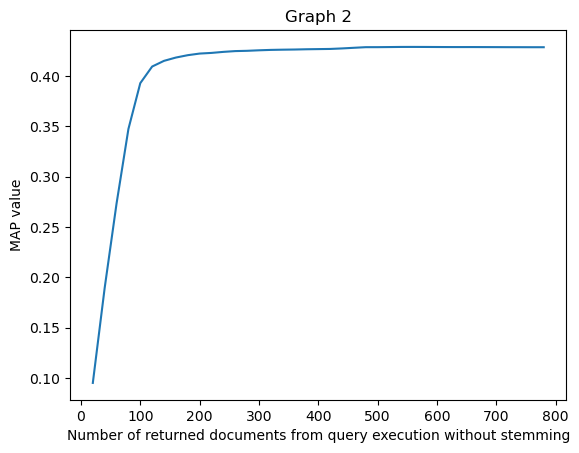

In [166]:
import matplotlib.pyplot as plt

plt.plot(y, x_map_nostem)
plt.xlabel('Number of returned documents from query execution without stemming')
plt.ylabel('MAP value')
plt.title('Graph 2')
plt.show()

In [176]:
maxmap = np.array(x_map)
max_index = maxmap.argmax()
print(max(x_map))
print(y[max_index])

0.4286660657299366
560


In [182]:
maxmap_nostem = np.array(x_map_nostem)
max_index = maxmap_nostem.argmax()
print(max(x_map_nostem))
print(y[max_index])

0.4286763870445832
560
